# EDU Segmentation using Neural Network


#### Notebook Guide
The implementation in the notebook consists of following stages :<br>
1. Reading the Corpus<br>
2. Converting Word2Vec<br>
3. Merging with feature vectors <br>
4. Neural Network training <br>
5. EDU segmentor Results <br>


- **All cells are executable**, however some cells need long time to execute. These cells are marked with **warnings**. 
- For cells that take long execution time (like neural network training) or need additional files (like the RST-Corpus), **pre-generated files are provided in the data/segmentor folder**.

<div class="alert alert-block alert-info"> Comments and hints are added in **blue** blocks </div>
<div class="alert alert-block alert-warning"> Warnings are added in **Yellow** blocks </div>


In [199]:
#####################################
########## Library Imports ##########
#####################################

import os.path
import glob
import nltk
import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import pickle
from collections import defaultdict

In [204]:
#####################################
############ Constants ##############
#####################################

N_GRAM = 4
W2V_SIZE = 100
PATH = "data/segmentor/"
W2V_FILENAME = PATH + "word2vec-RSTCorpus"
B_ARRAY = np.array([1,0],dtype=np.float64) # The Neural network output expected for EDU Break class
C_ARRAY = np.array([0,1],dtype=np.float64) # The Neural network output expected for EDU Continue class
NN_MODEL_FILES = PATH + "nnModel_"         #file name prefixes for storing trained neural net models


## 1) Reading the Corpus

In [202]:
'''
Reads the RST-DT corpus data and
Returns all sentences tokenized to words and the expected EDU breaks for each of these sentences
Attention : The internal folder structure of the corpus must not be altered. 
'''
def readCorpus(relDir, dataClass):    
    #go to the corpus dir  
    if((dataClass.upper() != "TRAINING") and (dataClass.upper() != "TEST")):
        raise ValueError("Value of 'dataClass' is incorrect. Select one of the following - 1)'TRAINING' 2)'TEST'")
    else:
        relDir +=  "/data/RSTtrees-WSJ-main-1.0/" + dataClass.upper() + "/"
        fileext = "*.edus"        
 
    absDir = os.path.join(os.getcwd(), relDir)
    
    if(os.path.isdir(absDir)):
        print("Reading corpus from "+ absDir)
    else:
        raise ValueError("The dir " + absDir +" is incorrect or doesnot exist. Please check check the value set in 'relDir' ")
            
    files = os.path.join(absDir, fileext)
    
    tokens = []
    edu_idx = []
    for fname in sorted(glob.glob(files)):
        with open(fname, 'r', encoding='utf-8') as doc:
            sent=[]
            edu_boundary = []
            for edu in doc:
                # tokenize to words
                edu_tokens = nltk.word_tokenize(edu)
                
                if edu_tokens[-1] not in ["!", "?", ".", "..."]:
                    # join EDUs of a sentence
                    sent.extend(edu_tokens)
                    # remember EDU boundary indices
                    edu_boundary.append(len(sent) - 1)
                else:
                    sent.extend(edu_tokens)
                    tokens.append(sent)
                    edu_idx.append(edu_boundary)
                    # clear for next sentence
                    sent = []
                    edu_boundary = []
            
    return tokens,edu_idx

<div class="alert alert-block alert-info"> **Note: **Below generation code is commented out as it requires the RST Corpus folder.<br> The data generated by the below code is provided as pickle files  </div>

In [203]:
# tokenized_train_data,train_EDUs = readCorpus("../../RST_corpus", "Training")
# tokenized_test_data,test_EDUs = readCorpus("../../RST_corpus", "Test")

# f_tokenized_train_data = open( "data/segmentor/tokenized_train_data.p", "wb" )
# f_tokenized_test_data = open( "data/segmentor/tokenized_test_data.p", "wb" )
# f_train_EDUs = open( "data/segmentor/train_EDUs.p", "wb" )
# f_test_EDUs = open( "data/segmentor/test_EDUs.p", "wb" )

# pickle.dump(tokenized_train_data, f_tokenized_train_data)
# pickle.dump(tokenized_test_data, f_tokenized_test_data)
# pickle.dump(train_EDUs, f_train_EDUs)
# pickle.dump(test_EDUs, f_test_EDUs)

# f_tokenized_test_data.close()
# f_tokenized_test_data.close()
# f_train_EDUs.close()
# f_test_EDUs.close()

Reading corpus from /media/roshanrane/DATA/Study/Masters/Workspace/ANLP/ANLP_assignmentFinal/repo/RST-parser/../../RST_corpus/data/RSTtrees-WSJ-main-1.0/TRAINING/
Reading corpus from /media/roshanrane/DATA/Study/Masters/Workspace/ANLP/ANLP_assignmentFinal/repo/RST-parser/../../RST_corpus/data/RSTtrees-WSJ-main-1.0/TEST/


In [205]:
#read pre-generated tokens from the RST corpus
with open( PATH+"tokenized_train_data.p", "rb" ) as file:
    tokenized_train_data = pickle.load(file)

with open( PATH+"tokenized_test_data.p", "rb" ) as file:
    tokenized_test_data = pickle.load(file)

with open( PATH+"train_EDUs.p", "rb" ) as file:
    train_EDUs = pickle.load(file)
    
with open( PATH+"test_EDUs.p", "rb" ) as file:
    test_EDUs = pickle.load(file)

## 2) Word2Vec 

<div class="alert alert-block alert-warning">
**Warning: Donot Execute the below cell **
<br>
If the word2vecs are regenerated the **the complete training must be repeated** for the new vectors which takes approx **6 hours** on an intel-i7 CPU
</div>

/home/roshanrane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


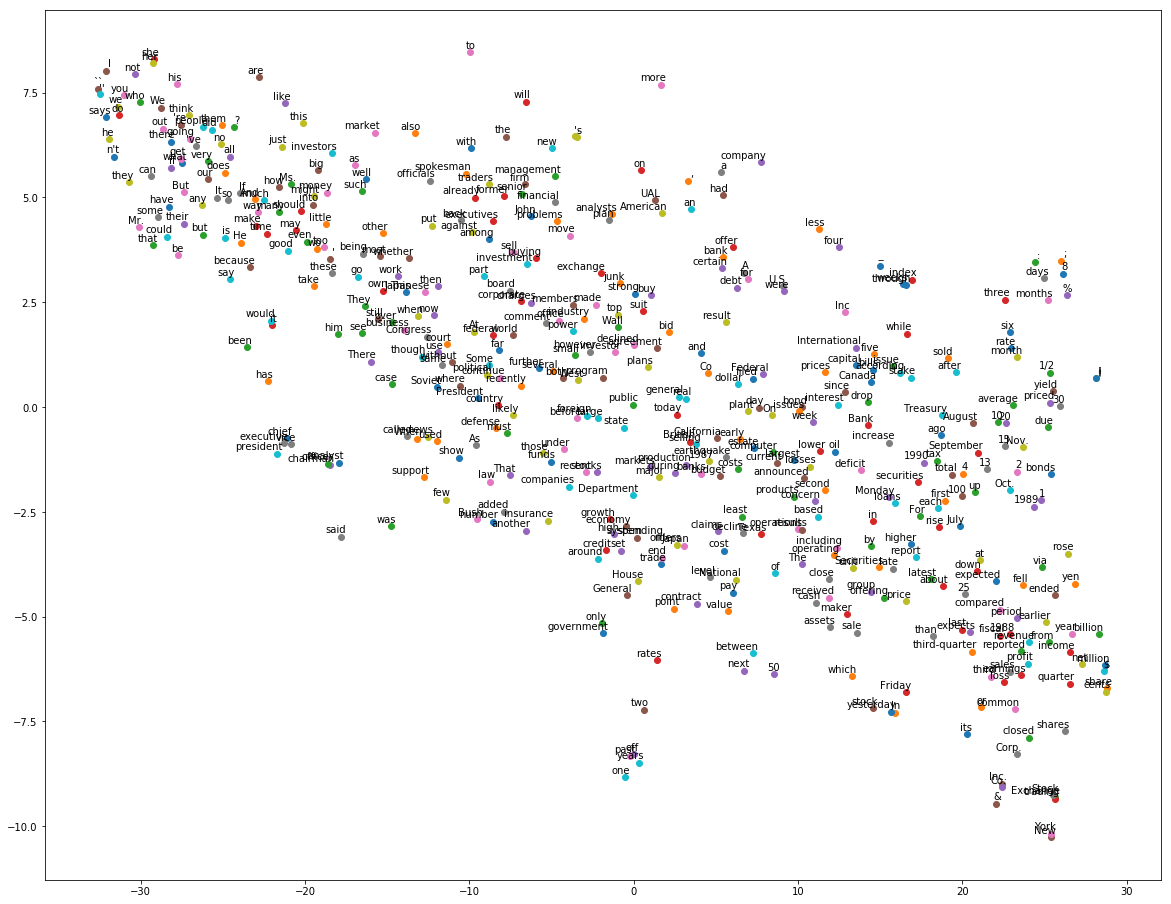

In [198]:
'''Plot the Word vectors generated in 2D for visualization '''
def w2v_visualizer(model):
    labels = []
    tokens = []
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    # use the TSNE model from scikit to reduce the dimensions from 1000s to 2
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    #extract the x and y axis and plot a scatter graph
    x = [value[0] for value in new_values]
    y = [value[1] for value in new_values] 
    plt.figure(figsize=(20, 16)) 
    
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
        
    plt.show()
    

'''Generate Word2Vec for all words in the corpus'''
def gen_w2v(tokenized_data, veclen, filename, visualize = False):
    # Word2Vec - Convert each word token to a vector of size 'veclen'
    model = gensim.models.Word2Vec(tokenized_data, size= veclen , window=20, min_count=1)
    # Save model as a file
    file = model.save(filename)
    if(visualize):
        w2v_visualizer(model)
    #delete the model to save RAM space
    del model

#########################################################################################################################

gen_w2v(tokenized_train_data + tokenized_test_data, W2V_SIZE, W2V_FILENAME, visualize = False)

<div class="alert alert-block alert-info"> **Comment: ** It can be observed that tokens like 'because', 'that', 'but' which signal a possible EDU break  are preferrably grouped in the top left. However this is not the general case. Other EDU-hinting tokens such as comma are in a different region and non-EDU-hinting words like 'is' are in the same region as  'that' or 'but'. Therefore Word2Vecs might not be enough to predict EDU boundaries. </div>

## 3) Merging with feature vectors 

In [7]:
''' Takes Corpus extractions and EDU boundaries and converts it to input vectors and 
output vectors to feed to the Neural Network.
Concatenates the words in n-grams and stitches the Word Embeddings and feature vectors of each word.
Output is a 2-element vector : [1,0] meaning EDU Break
                             : [0,1] meaning no EDU Break '''
def extract_nnVec(tokenized_data, edu_lists, model, features_df, n_gram):
    
    nnData = []
    features_len = len(features_df.columns) - 1
    total_words = 0
    
    for sent,EDUs in zip(tokenized_data, edu_lists):        
        # Extend the sentences on both ends with 'empty space' tokens. This will ensure that no words are missed.
        # One n-gram sequence will exist for every word pair in the original sentence, with the word pair as it's he mid point in it.
        ext = [" " for i in range((n_gram//2) -1)]
        index_offset = len(ext)
        extended_sent = ext + sent + ext        
        
        # get word2Vecs + featureVecs of each word of the n-gram and stack them together
        for i in range(len(extended_sent)- n_gram + 1):
            
            word = extended_sent[i]
            #if the word is a filler 'empty space' token then return 0 vectors
            if(word == " "):
                nnDat_in = np.zeros(model.vector_size + features_len, dtype=np.float64)
            else:
                nnDat_in = np.concatenate((model.wv[word], getFeatureVecs(features_df, total_words+i-index_offset, word )))                
                
            #collect the next (n-1) words of the n-gram
            for j in range(1,n_gram) :
                
                word = extended_sent[i+j]
                
                if(word == " "):
                    nnDat_in = np.concatenate((nnDat_in, np.zeros(model.vector_size + features_len, dtype=np.float64)))
                else:
                    nnDat_in = np.concatenate((nnDat_in, model.wv[word], getFeatureVecs(features_df, total_words+i-index_offset+j, word)))
                    
            #check if there is an EDU break in between the n-gram.
            mid_index = (i - index_offset + n_gram//2 - 1)
            
            if(mid_index in EDUs):
                nnDat_out = B_ARRAY # EDU 'Break' class
            else:
                nnDat_out = C_ARRAY # EDU 'Continue' class
                
            nnData.append((nnDat_in, nnDat_out))
            
        # increment the total words index by the number of words that were in the sent
        total_words += len(sent)  
        
    return nnData


'''Reads a csv file containing pre-generated features that are converted to vectors and extracts vectors in neccessary formats and'''
def extractFeatures(csvFile):
    df = pd.read_csv(csvFile)
    #delete unneccesary columns. Removing top_syntactic tag features
    delCols = ['file_name','sent_word_indices']
    df = df.drop(delCols,axis = 1)
    return df


''' Reads the features from the dataframe, checks if the word is correct and
returns feature vectors as an np array'''
def getFeatureVecs(df, idx, word):
    csvword = df.iloc[idx].loc['word']
    # Ensure the features are read for the expected word 
    assert(csvword in [word,'OPENING_ROUND_BRACE', 'CLOSING_ROUND_BRACE']),\
    "The word in the csv '{}' is not matching with the word '{}' at the index {}".format(csvword, word, idx)
    return np.array(df.iloc[idx].iloc[1:],dtype=np.float64)

In [229]:
Load word vectors and Features previously generated for the test corpus 
w2v_model = gensim.models.Word2Vec.load(W2V_FILENAME)
features_test_df = extractFeatures("data_set_1__test.csv")

#generate Vectors for test data
testVecs = extract_nnVec(tokenized_test_data, test_EDUs, w2v_model, features_test_df, n_gram = N_GRAM)

nn_in_dem = testVecs[0][0].shape[0]
nn_out_dem = 2
del w2v_model

print("Each word is represented by {} word2vecs + {} feature vectors. \nThese words are grouped in {}-grams. \nThe resulting in a total {} input vector size. ".format(W2V_SIZE, 181, N_GRAM, nn_in_dem))

Each word is represented by 100 word2vecs + 181 feature vectors. 
These words are grouped in 4-grams. 
The resulting in a total 1116 input vector size. 


<div class="alert alert-block alert-warning">
**Warning: Donot Execute the below cell**
<br>The cell takes approx. **8 mins** and large RAM space for execution.<br>
The results can still be viewed without generating the training vectors as a pre-trained model is provided.
</div>

In [239]:
# Load word vectors and Features previously generated for the training corpus 
w2v_model = gensim.models.Word2Vec.load(W2V_FILENAME)
features_train_df = extractFeatures("data_set_1__train.csv")

#generate Vectors for training data
trainingVecs = extract_nnVec(tokenized_train_data, train_EDUs, w2v_model, features_train_df, n_gram = N_GRAM)
del w2v_model

#### Evaluator

In [230]:
'''Evaluates the neural net model on the test data and calculates the Precision, Recall and F1 scores.
Returns the F1-score '''
def evaluateModel(nnModel, testVecs, threshold = 0, printDebugs = False):
    # calculate the True Positives, False Positives, True Negatives and False Negatives
    TP = FP = TN = FN = 0
    predictions = []

    for in_vec, expected_vec in testVecs:

        # Get the predictions of the neural network model and 
        predicted_vec = nnModel.predict(in_vec).reshape(-1)
        
        # Check if the Neural Network, is predicting a EDU 'Break' or a EDU 'Continue'
        if((predicted_vec[0] - predicted_vec[1]) > threshold ):
            predicted = "B"
        else:
            predicted = "C"
        predictions.append(predicted)
        
        if(np.array_equal(expected_vec, B_ARRAY)):
            expected = 'B'
        else:
            expected = 'C'      
            
        if((expected == 'B') and (predicted == 'B')):
            TP += 1
        elif((expected == 'B') and (predicted == 'C')):
            FN += 1
        elif((expected == 'C') and (predicted == 'B')):
            FP += 1
        elif((expected == 'C') and (predicted == 'C')):
            TN += 1

    if(printDebugs): 
        print("TP {},FN {},FP {},TN {}".format(TP,FN,FP,TN))

    #recall, Precision and F1-score calculation
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    F1 = 100*2*recall*precision/(recall + precision)      

    if(printDebugs): 
        print("Recall = {}% \nPrecision = {}% \n F1-Score = {}% \n".format(recall*100, precision*100, F1))

    return F1, predictions


## 4) Neural Network

In [231]:
'''Feed forward Neural Network with Stochastic Gradient descent '''

class myNNet():    
    ''' layers: A list denoting how many neurons each layer must contain. 
    The size of the list defines the number of layers.
    Example [100,500,200,2] imples the input layer has 100 neurons, there are 2 hidden layers with 500 and 200 neurons each
    and output layer has 2 neurons '''
    
    def __init__(self,layers, reg_lamda = 0.0001):        
        #initialise the Weights and biases of the model
        np.random.seed(1)
        self.L = layers
        self.num_layers = len(layers)
        self.w = [] # weights
        self.b = [] # bias
        self.Lambda = reg_lamda # lambda hyper parameter for regularization
        for i in range(len(layers) - 1):
            self.w.append(2 * np.random.random((layers[i], layers[i+1])) - 1)
            self.b.append(np.zeros((1,layers[i+1]), dtype=np.float64))
    
    def __str__(self):
        
        note = "Neural Network Model containing:"
        for i in range(self.num_layers):
            if (i != self.num_layers-1):    
                note += ("\nlayer{} = {} Nodes {} Weights {} Biases".format(i, self.L[i], self.w[i].shape, self.b[i].shape))
            else:
                note += ("\nlayer{} = {} Nodes".format(i, self.L[i]))
        return note
    
    
    '''returns the softmax values of the layer '''
    def __sftmax(self,nodes):
        exps = np.exp(nodes - np.max(nodes))
        return exps / np.sum(exps)

    '''returns the nonLin transformation '''
    def __Sigmoid(self,z):
        z=np.array(z,dtype=np.float64)
        return (np.tanh(z))        
    
    '''returns the derivative of the nonLin transformation function  '''
    def __dSigmoid(self,z):
        z=np.array(z,dtype=np.float64)
        return (1-np.tanh(z)**2)
        
    
    '''Feeds the given input vector into the Neural network and returns the predicted output
    If getAllLayers is set True then all neurons and Z values are returned, this is needed while training. '''
    def predict(self, dat_in, getAllLayers = False):
        # input data is directly the neuron values of the 1st layer
        neurons = [dat_in.reshape(1,self.L[0])]
        z = []

        for L in range(self.num_layers - 1):
            z.append(neurons[L].dot(self.w[L]) + self.b[L])
            if(L != (self.num_layers - 2)):
                neurons.append( self.__Sigmoid(z[L]))
            else: #for the last layer perform softmax instead of Sigmoid
                neurons.append( self.__sftmax(z[L]))
        
        if(getAllLayers):
            return neurons, z
        else: 
            return neurons[-1]
    
    
    ''' Calculates the cost value in the model. This is used for checking the progress in the model training '''
    def calcCost(self, predicted, expected):
        totalCost = 0
        for p,e in zip(predicted, expected):
            totalCost += (np.log(p)*e).sum()
        #add regularization factor
#         totalCost += (self.Lambda/2)*sum((w**2).sum() for w in self.w)
        return totalCost/len(predicted)
    
    
    '''The main method where the model is trained using back propagation. 
    learn_rate and reg_lamba are 2 hyper-parameters of the model
    If debugPrintCycles is set to 0, nothing is printed. If it is set to any other value, 
     various training information is printed every debugPrintCycle for checking progress '''
    def train(self, data, passes, learn_rate = 0.01, debugPrintCycles = 0):        
        
        print("\nStarting training cycles...") 
        data_size = len(data)
        
        # if debugPrints is requested then plot the F1 evaluation and Loss values at every debug cycle
        if(debugPrintCycles):
            loss_values = []
            F1_scores = []
            pass_idx = []
            
        for i in range(passes):
            
            #create mini batches of randomly shuffled training data for stochastic gradient descent
            np.random.shuffle(data)
            num_of_mini_batches = len(str(data_size))            
            mini_batch_size = data_size//num_of_mini_batches           
            mini_batches = [data[i:i+mini_batch_size] for i in range(num_of_mini_batches)]

            outputs = []
            # matrices to store nudges of backpropogation
            b_nudges = [np.zeros(b.shape,dtype=np.float64) for b in self.b]
            w_nudges = [np.zeros(w.shape,dtype=np.float64) for w in self.w]
            
            if(debugPrintCycles): j = 0
            
            for mini_batch in mini_batches:
                for dat_in, dat_out in mini_batch:  

                    # forward propagation    
                    neurons,z = self.predict( dat_in, getAllLayers = True)                
                    outputs.append(neurons[-1])

                    if(debugPrintCycles):
                        if not(i% debugPrintCycles): 
                            if(j == 0):
                                print("\nResults after {} training cycles : ".format(i))                                            
                            j += 1

                    # back propagation                           
                    # get the partial derivatives for last layer
                    dz = (outputs[-1] - dat_out)         
                    b_nudges[-1] += dz
                    w_nudges[-1] += neurons[-2].T.dot(dz)

                    # get the partial derivatives for the rest of the layers
                    for L in range(2, self.num_layers):
                        dCost = dz.dot(self.w[-L+1].T) 
                        dz = self.__dSigmoid(z[-L]) * dCost
                        b_nudges[-L] += dz
                        w_nudges[-L] += neurons[-L-1].T.dot(dz) 

                # update the gradient descents learned
                self.b = [(b-(learn_rate/mini_batch_size)*nb) for b, nb in zip(self.b, b_nudges)]
                self.w = [(w-(self.Lambda/data_size)*w-(learn_rate/mini_batch_size)*nw) for w, nw in zip(self.w, w_nudges)]
            
            if(debugPrintCycles):
                if not (i% debugPrintCycles):
                    
                    # calculate loss value
                    expected = [dat_out for dat_in, dat_out in data]
                    cost = self.calcCost(outputs, expected)
                    print("Loss = {}".format(cost))
                    # calculate Accuracy 
                    F1,_ = evaluateModel(self, testVecs, 0.0)
                    print("F1 = {}".format(F1))

                    pass_idx.append(i)
                    loss_values.append(cost)
                    F1_scores.append(F1)
                    
                    self.saveModel(str(i))
        
        print("Finished Training ! ")
        self.saveModel(str(passes))
        
        if(debugPrintCycles): 
            # plot F1-scores and loss v/s training cycles 
            f, ax1 = plt.subplots()
            ax1.set_title("NeuralNet Loss v/s training cycles")
            ax1.xlabel = "Training cycles"
            ax1.ylabel = "Loss in the model"
            ax1.plot(pass_idx, loss_values, 'b')
            f, ax2 = plt.subplots()
            ax2.set_title("F1-scores v/s training cycles")
            ax2.xlabel = "Training cycles"
            ax2.ylabel = "Accuracy of Prediction"
            ax2.plot(pass_idx, F1_scores, 'r')
            plt.show()
            
    
    '''Saves the model parameter in out files that can be loaded later using updateModel() '''
    def saveModel(self, suffix):
        saveFile = NN_MODEL_FILES + "_".join(str(l) for l in self.L[0:-1]) +"_" + suffix
        
        np.save(saveFile + "_w", self.w)
        for b_i, b in enumerate(self.b):
            np.save(saveFile + "_b"+ str(b_i), b)
        print(".. saved model params in {} files".format(saveFile))
        
        
    '''Method loads a previously trained model saved in npy files and updates the current parameters. '''
    def updateModel(self, suffix):        
        loadFile = NN_MODEL_FILES + "_".join(str(l) for l in self.L[0:-1]) +"_" + suffix
        
        self.w = np.load(loadFile + "_w" + ".npy")        
        for b_i in range(len(self.b)):
            self.b[b_i] = np.load(loadFile + "_b"+ str(b_i) + ".npy")
        print(".. updated model with params from {} files".format(loadFile))

In [263]:
# 2 hidden layers with 100 nodes and 10 nodes each
layers = [nn_in_dem, 100, 10, nn_out_dem]

segmentor = myNNet(layers)
print(segmentor)

train_passes = 1800

# update parameters of the model from a previously trained model
segmentor.updateModel(str(train_passes))

Neural Network Model containing:
layer0 = 1116 Nodes (1116, 100) Weights (1, 100) Biases
layer1 = 100 Nodes (100, 10) Weights (1, 10) Biases
layer2 = 10 Nodes (10, 2) Weights (1, 2) Biases
layer3 = 2 Nodes
.. updated model with params from data/segmentor/nnModel_1116_100_10_1800 files


<div class="alert alert-block alert-warning">
**Warning: Donot Execute the below cell if not necessary **
<br>The cell takes approx. **15 mins** for execution.<br>
The results can still be viewed without generating the training vectors as a pre-trained model is provided.
</div>

In [ ]:
# train for 20 cycles for demonstration
segmentor.train(trainingVecs, 20, debugPrintCycles = 4)

<div class="alert alert-block alert-info"> Graphs of *F1-score on test data* and *Loss on training data* were generated during training. These graph **help to identify where over-fitting might occur**. Once the models starts to over-fit to training data, the F1 scores on test data starts dropping. Regularization Lamda was derived using these graphs. <br> The final graphs generated after over-fitting was handled : <div><br>
<img src="screenshots/segmentor/Training_1116vectors_withfeatures.png">

In [264]:
F1_score, nn_predictions = evaluateModel(segmentor, testVecs, threshold = 0.00, printDebugs = True)

TP 1120,FN 334,FP 222,TN 19017
Recall = 77.02888583218707% 
Precision = 83.4575260804769% 
 F1-Score = 80.11444921316165% 



<div class="alert alert-block alert-info">Our segmentor generates an F1-score of **80.11%** where as the state-of-the-art in Feng's approach generates a result of **92.6 %** <div>

## 5) EDU segmentation results

In [253]:
'''Function generates corpus files incorporating the EDU breaks predicted by the model.
The EDU break is represented by a newline in the file.
The files are generated with the same file name but with an extension .edus '''
def gen_Segmentation_Results(fnames, tokens, predictions):
    
    filesDict = defaultdict(str)
    sent_count = 0
    word_count = 0
    
    for sent_i, sent in enumerate(tokens):
        edu_sent = ""
        for word_i, word in enumerate(sent):
            edu_sent += " " + word
            
            # if it's the last word in the sent then write to dict and move on
            if(word_i == (len(sent)-1)):                
                file = fnames[word_count]
                filesDict[file] += (edu_sent + "\n")
                
            #if an EDU break is predicted by the model then add a newline in the file
            elif(predictions[word_i + word_count - sent_count] == 'B'):
                edu_sent += "\n"
                
        word_count += len(sent)
        sent_count += 1
        
    allFiles = sorted(set(fnames))
    for fname in allFiles:      
        with open(PATH + "results/"+fname+".edus", "w+") as f:
                  f.write(filesDict[fname])
    print("EDU-seperated files successfully generated in data/results folder.")

#########################################################################################################################
#get the file_names in the sorted order
df = pd.read_csv("data_set_1__test.csv", usecols=["file_name","word"])
test_fileNames = list(df.file_name)

gen_Segmentation_Results(test_fileNames, tokenized_test_data, nn_predictions )

EDU-seperated files successfully generated in data/results folder.


### Comparing results -
#### Original Sentences ( file: wsj_0607) :
<div class="alert alert-block alert-info"> 
 Three new issues begin trading on the New York Stock Exchange today ,
 and one began trading on the Nasdaq/National Market System last week.<br>
 El Paso owns
 and operates a petroleum refinery.<br>
 Franklin is a closed-end management investment company.<br>
 On the Nasdaq over-the-counter system , Allied Capital Corp. ,
 Washington , D.C. , ( ALII ) began
 trading last Thursday.<br>
 Allied Capital is a closed-end management investment company
 that will operate as a business development concern.<br>
<br></div>

#### Sentences grouped in EDUs by our segmentor :
<div class="alert alert-block alert-info"> 
 [Three new issues begin trading on the New York Stock Exchange today, ]
[ and one began trading on the Nasdaq/National Market System last week. ]<br>
 [ El Paso owns and operates a petroleum refinery . ]<br>
 [ Franklin is a closed-end management investment company. ]<br>
 [ On the Nasdaq over-the-counter system , Allied Capital Corp. , ]
 [ Washington , D.C. , ( ALII ) began ]
 [ trading last Thursday . ]<br>
 [ Allied Capital is a closed-end management investment company ]
 [ that will operate as a business development concern . ]<br>
 </div>
 
 #### Sentences grouped in EDUs in the corpus :
<div class="alert alert-block alert-info"> 
 [Three new issues begin trading on the New York Stock Exchange today, ]
[ and one began trading on the Nasdaq/National Market System last week. ]<br>
 [ El Paso owns and operates a petroleum refinery . ]<br>
 [ Franklin is a closed-end management investment company. ]<br>
 [ On the Nasdaq over-the-counter system , Allied Capital Corp. ,  Washington , D.C. ,]
 [( ALII ) ]
 [ began trading last Thursday . ]<br>
 [ Allied Capital is a closed-end management investment company ]
 [ that will operate as a business development concern . ]<br>
 </div>